In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype as Category
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np
from iterextras import par_for
import subprocess as sp
import os
import itertools
from tqdm.auto import tqdm
import rs_utils
from scipy.stats import gmean
import matplotlib as mpl
import json
import statsmodels.formula.api as sm
from matplotlib import rc

sns.set()

In [2]:
PATHS = glob('../data/*.json')
CRATES = [os.path.splitext(os.path.basename(path))[0] for path in PATHS]
CATEGORIES = {
    'mutability_mode': Category(["DistinguishMut", "IgnoreMut"]),
    'context_mode': Category(["Recurse", "SigOnly"]),
    'pointer_mode': Category(["Conservative", "Precise"]),
    'crate': Category(sorted(CRATES))
}

def parse_data(path):
    print(path)
    if os.stat(path).st_size == 0:
        return []
    
    crate = os.path.splitext(os.path.basename(path))[0]
    df = pd.DataFrame(rs_utils.parse_data(path))
    df['crate'] = crate
    for k, dt in CATEGORIES.items():
        df[k] = df[k].astype(dt)
    return df


all_dfs = par_for(parse_data, PATHS)
df = pd.concat(all_dfs).reset_index()
del all_dfs

df['ins_rel_nonzero'] = df.instructions_relative > 0
df['ins_rel_frac_log'] = np.log(df.instructions_relative_frac)

../data/rav1e.json
../data/hyper.json
../data/image.json
../data/RustPython.json
../data/rg3d.json
../data/rayon.json
../data/rustls.json
../data/Rocket.json
../data/nalgebra.json
../data/sccache.json


  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
def cond(df, m=None, c=None, p=None):
    if m is not None:
        df = df[df.mutability_mode == m]
    if c is not None:
        df = df[df.context_mode == c]
    if p is not None:
        df = df[df.pointer_mode == p]
    return df

modular_cond = cond(df, c='SigOnly', m='DistinguishMut', p='Precise')
modular_metric = modular_cond.instructions_relative_frac
mutblind_cond = cond(df, c='SigOnly', m='IgnoreMut', p='Precise')
mutblind_metric = mutblind_cond.instructions_relative_base_frac
refblind_cond = cond(df, c='SigOnly', m='DistinguishMut', p='Conservative')
refblind_metric = refblind_cond.instructions_relative_base_frac
whole_cond = cond(df, c='Recurse', m='DistinguishMut', p='Precise')

# Dataset (Section 5.1)

## Crate information (Table 1)

In [11]:
CRATE_INFO = [
    ('Rocket', 'core/lib', 'Web backend framework', 'https://github.com/SergioBenitez/Rocket'),
    ('image', None, 'Image processing library', 'https://github.com/image-rs/image'),
    ('rayon', None, 'Data parallelism library', 'https://github.com/rayon-rs/rayon'),
    ('rg3d', None, '3D game engine', 'https://github.com/mrDIMAS/rg3d'),    
    ('nalgebra', None, 'Numerics library', 'https://github.com/dimforge/nalgebra'),
    ('rustls', 'rustls', 'TLS implementation', 'https://github.com/ctz/rustls'),
    ('sccache', None, 'Distributed build cache', 'https://github.com/mozilla/sccache'),
    ('hyper', None, 'HTTP server', 'https://github.com/hyperium/hyper'),    
    ('rav1e', None, 'Video encoder', 'https://github.com/xiph/rav1e'),
    ('RustPython', 'vm', 'Python interpreter', 'https://github.com/RustPython/RustPython'),
]

In [12]:
modular_cond_funcs = modular_cond.groupby(['crate', 'function_path']) \
    .apply(lambda df: df.iloc[0]).reset_index(drop=True)
num_slices = modular_cond.groupby(['crate']).size().rename('num_slices')
avg_ins_per_func = modular_cond_funcs.groupby('crate').num_instructions.mean() \
    .rename('avg_ins_per_func')
num_funcs = modular_cond.groupby(['crate']).apply(lambda df: len(df.function_path.unique())).rename('num_funcs')

q = modular_cond.groupby(['crate', 'function_path']).size()
avg_slices_per_func = q[q > 0] \
    .groupby('crate').mean().rename('avg_slices_per_func')
crate_stats = pd.concat(
    [num_slices, avg_ins_per_func, num_funcs, avg_slices_per_func], 
    axis=1).sort_values('num_slices')
crate_stats

,num_slices,avg_ins_per_func,num_funcs,avg_slices_per_func
crate,,,,
rayon,10607,16.569045,1079,9.830399
Rocket,12040,25.527665,741,16.248313
rustls,23407,42.447005,868,26.966590
sccache,23680,61.555210,643,36.827372
nalgebra,35886,26.671148,1785,20.104202
image,39077,56.808394,1096,35.654197
hyper,44900,82.887342,790,56.835443
rg3d,59590,25.713167,3448,17.282483
rav1e,76749,115.366273,931,82.437164


In [16]:
CLOC = '/home/wcrichto/.node_modules/bin/cloc'
crate_loc = []
for (crate, path, purpose, url) in CRATE_INFO:
    crate_dir = f'../data/repos/{crate}'
    if path:
        crate_dir += f'/{path}'
    crate_dir += '/src'    
    cloc_str = sp.check_output(f'{CLOC} {crate_dir} --json', shell=True).strip()
    commit = sp.check_output('git rev-parse HEAD', shell=True, cwd=crate_dir).strip().decode('utf-8')
    cloc = json.loads(cloc_str)
    crate_loc.append({
        "crate": crate,
        'subdir': path,
        'purpose': purpose,
        "url": url,
        "commit": commit,
        "loc": cloc["Rust"]["code"],
    })
crate_loc = pd.DataFrame(crate_loc)

In [17]:
crate_final = crate_stats.join(crate_loc.set_index("crate")).sort_values('num_slices')
for crate, row in  crate_final.iterrows():
    print(f'\href{{{row.url}}}{{{crate}}} & {row.subdir or ""} & {row.purpose} & {row["loc"]:,} & \
{row.num_slices:,} & {row.num_funcs:,} & {row.avg_ins_per_func:.1f} \\\\ \hline')

\href{https://github.com/rayon-rs/rayon}{rayon} &  & Data parallelism library & 15,524 & 10,607 & 1,079 & 16.6 \\ \hline
\href{https://github.com/SergioBenitez/Rocket}{Rocket} & core/lib & Web backend framework & 9,313 & 12,040 & 741 & 25.5 \\ \hline
\href{https://github.com/ctz/rustls}{rustls} & rustls & TLS implementation & 16,866 & 23,407 & 868 & 42.4 \\ \hline
\href{https://github.com/mozilla/sccache}{sccache} &  & Distributed build cache & 23,202 & 23,680 & 643 & 61.6 \\ \hline
\href{https://github.com/dimforge/nalgebra}{nalgebra} &  & Numerics library & 31,951 & 35,886 & 1,785 & 26.7 \\ \hline
\href{https://github.com/image-rs/image}{image} &  & Image processing library & 20,722 & 39,077 & 1,096 & 56.8 \\ \hline
\href{https://github.com/hyperium/hyper}{hyper} &  & HTTP server & 15,082 & 44,900 & 790 & 82.9 \\ \hline
\href{https://github.com/mrDIMAS/rg3d}{rg3d} &  & 3D game engine & 54,426 & 59,590 & 3,448 & 25.7 \\ \hline
\href{https://github.com/xiph/rav1e}{rav1e} &  & Video enc

In [18]:
print(f'{crate_final["loc"].sum():,} & {crate_final.num_slices.sum():,} & {crate_final.num_funcs.sum():,}')

285,307 & 423,533 & 14,696


In [20]:
crate_final.reset_index()[['crate', 'commit']]

,crate,commit
0,rayon,c571f8ffb4f74c8c09b4e1e6d9979b71b4414d07
1,Rocket,8d4d01106e2e10b08100805d40bfa19a7357e900
2,rustls,cdf1dada21a537e141d0c6dde9c5685bb43fbc0e
3,sccache,3f318a8675e4c3de4f5e8ab2d086189f2ae5f5cf
4,nalgebra,984bb1a63943aa68b6f26ff4a6acf8f68b833b70
5,image,e916e9dda5f4253f6cc4557b0fe5fa3876ac18e5
6,hyper,ed2fdb7b6a2963cea7577df05ddc41c56fee7246
7,rg3d,ca7b85f2b30e45b82caee0591ee1abf65bb3eb00
8,rav1e,1b6643324752785e7cd6ad0b19257f3c3a9b2c6a
9,RustPython,9143e51b7524a5084d5ed230b1f2f5b0610ac58b


## Execution time (last paragraph of 5.1)

In [22]:
durations = cond(df, m='DistinguishMut', p='Precise').groupby(['context_mode', 'function_path']) \
    .apply(lambda df: df.iloc[0].duration)
durations.groupby('context_mode').median() * 1e3


# Quantitative analysis (Section 5.2)

In [30]:
def plot_ins(data, xscale='linear', yscale='linear', nz=False, ax=None, quantile=None, bins=None, **kwargs):
    if nz:
        data = data[data > 0]        
        
    if bins is None:
        max = data.max()
        if 'log' in xscale:
            bins = np.logspace(np.log10(0.0001), np.log10(max))
            if not nz:
                bins = np.concatenate(([0.], bins))
        else:
            bins = np.linspace(0, max, 30)

    ax = sns.histplot(data, bins=bins, ax=ax)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    if xscale == 'symlog':
        nz_min = data[data > 0].min()
        ax.set_xscale(xscale, linthresh=nz_min)
        ax.set_xlim(-nz_min/2, data.max())
        
    ax.set_xlabel('\% increase in dependency set size' + (', log scale' if 'log' in xscale else ''))
    ax.set_ylabel('Count' + (', log scale' if yscale == 'log' else ''))

    if quantile is not None:
        x = data.quantile(quantile)
        ax.axvline(x, color='r')        

## Figure 2

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


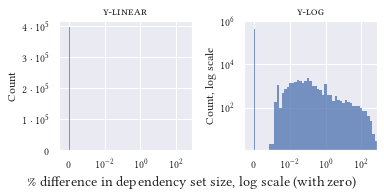

In [49]:
rc('font',**{'family':'serif','serif':['Linux Libertine O']})
rc('text', **{'usetex': True, 'latex.preamble': r'\usepackage{libertine}\usepackage[libertine]{newtxmath}'})

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(5.5, 3.))

plot_ins(modular_metric, ax=ax1, xscale='symlog')
ax1.set_title('\\textsc{y-linear}')
ax1.set_yticklabels(['0'] + [f'${n} \cdot 10^5$' for n in [1,2,3,4]])

plot_ins(modular_metric, xscale='symlog', yscale='log', ax=ax2)
ax2.set_title('\\textsc{y-log}')
ax2.set_yticks([10e1, 10e3, 10e5])

for ax in [ax1, ax2]:
    ax.set_xticks([0, 10e-3, 10e-1, 10e1])

ax1.set_xlabel('')
ax2.set_xlabel('')
fig.supxlabel('\% difference in dependency set size, log scale (with zero)', y=0.1)

fig.tight_layout()
fig.savefig('eval-recurse-dist.pdf', bbox_inches='tight')

## Figure 3

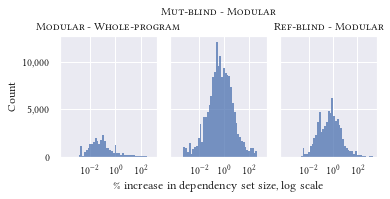

In [50]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(5.5, 3.), sharey=True)

kwargs = {'nz': True, 'xscale': 'log'}
plot_ins(modular_metric, ax=ax1, **kwargs)
ax1.set_title('\\textsc{Modular} - \\textsc{Whole-program}')
plot_ins(mutblind_metric, ax=ax2, **kwargs)
ax2.set_title('\\textsc{Mut-blind} - \\textsc{Modular}', y=1.125)
plot_ins(refblind_metric, ax=ax3, **kwargs)
ax3.set_title('\\textsc{Ref-blind} - \\textsc{Modular}')

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([10e-3, 10e-1, 10e1])
ax1.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax1.set_xlabel('')
ax3.set_xlabel('')

fig.tight_layout()

fig.savefig('eval-all-dist.pdf', bbox_inches='tight')

## Statistics used within 5.2 text

In [51]:
def stats(series):
    nz = len(series[series > 0]) / len(series)
    return f'{nz:.4f}, {1. - nz:.4f}, {series[series > 0].median():.2f}'

print('Modular:', stats(modular_metric))
print('MutBlind:', stats(mutblind_metric))
print('RefBlind:', stats(refblind_metric))

Modular: 0.0626, 0.9374, 0.07
MutBlind: 0.3943, 0.6057, 0.50
RefBlind: 0.1696, 0.8304, 0.56


## Figure 4

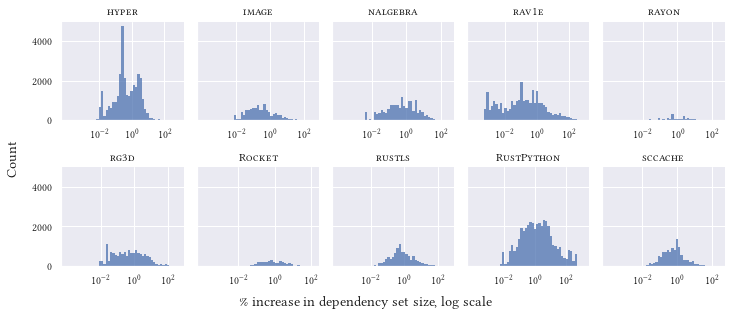

In [54]:
g = sns.FacetGrid(data=mutblind_cond, col='crate', col_order=sorted(CRATES, key=lambda s: s.lower()), 
                  col_wrap=5, sharex=False, height=2.3, aspect=0.9)
g.map_dataframe(lambda **kwargs: plot_ins(kwargs['data'].instructions_relative_base_frac, nz=True, xscale='log'))
g.set_titles('\\textsc{{{col_name}}}')
g.fig.supylabel('Count')
g.fig.supxlabel('\% increase in dependency set size, log scale', y=0.05)
for ax in g.axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([10e-3, 10e-1, 10e1])
    
g.fig.tight_layout()
g.fig.savefig('eval-crates.pdf', bbox_inches='tight')



# Threats to validity (Section 5.4)


## 5.4.1 statistics

In [55]:
total_vs_nz = mutblind_cond.groupby('crate').apply(lambda df: pd.DataFrame([{
    'total': crate_final.num_slices[df.crate.iloc[0]],
     'nz': len(df[df.instructions_relative_base > 0])
}]))
result = sm.ols('nz ~ total', data=total_vs_nz).fit()
result.summary()

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     nz   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     29.90
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           0.000596
Time:                        21:45:23   Log-Likelihood:                -100.56
No. Observations:                  10   AIC:                             205.1
Df Residuals:                       8   BIC:                             205.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -468.3470   3719.231     -0.126      0.903   -9044.909    8108.215
total          0.4054      0.074      5.468      0.001       0.234       0.576
==============================================================================
Omnibus:                        4.169   Durbin-Watson:                   2.186
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                1.148
Skew:                           0.731   Prob(JB):                        0.563
Kurtosis:                       3.787   Cond. No.                     9.36e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 5.4.2 statistics

In [25]:
len(modular_cond[modular_cond.reached_library]) / len(modular_cond)

0.9384392715561716

In [26]:
modular_cond.groupby('reached_library').apply(lambda df: len(df[df.ins_rel_nonzero]) / len(df))

reached_library
False    0.006597
True     0.066321
dtype: float64